*Prof. Stefano Diciotti*  
*University of Bologna*

---

**Academic Year:** 2024/2025  
**Student Name:** Alessandro Frullo  
**Degree Program:** Electronics for Intelligent Systems, IoT & Big Data  
**Submission Date:** 24/07/2025

# AI4M Project - Classification of EEG Signals: Imagery vs Rest

This project focuses on recognizing from EEG signals when a person is imagining a movement versus when they are resting. This is important for ***brain-computer interfaces (BCI)***, which can help people with disabilities and improve neurological rehabilitation.

The challenge is that EEG signals are often noisy, vary a lot between different subjects, and the data can be unbalanced. The goal is to build reliable machine learning models that can accurately decode these brain states.

# Project Overview Summary

This project focuses on classifying EEG signals to distinguish motor imagery from rest states using machine learning. The pipeline consists of **four main steps**:

1. **Data Loading & Preprocessing**  
   Load raw EEG data from EDF files, extract relevant channels and epochs around events, and prepare labeled datasets.

2. **Data Visualization & Exploration**  
   Analyze class distribution in training and testing data to ensure balanced representation and detect any anomalies.

3. **Model Evaluation & Metrics Visualization**  
   Train classifiers and visualize their performance through confusion matrices, precision-recall curves, and ROC curves. Save metrics logs for detailed analysis.

4. **Explainability & Feature Importance Analysis**  
   Use SHAP values to interpret model predictions, identifying the most influential EEG features and brain areas contributing to classification.

## Initial Setup

Download and extract the dataset into working folder from the provided URL:

https://drive.google.com/drive/folders/1V2ttNQQlGvlXf1sRaKJGmiE6U7T5s6TG?usp=sharing

Dataset folder structure:
- utils
- AIMed_Project_Frullo.ipynb
- emmi_dataset
  - files
    - S001
    - S002
    - ...
    - S109

In [1]:
# # --- Colab setup ---
# # Install required packages in Colab
# !pip install numpy pandas matplotlib tqdm pyedflib scikit-learn

# # Mount Google Drive and set working directory
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# project_path = "/content/drive/MyDrive/UniBO/AI4M_Project" # Change to your project path
# os.chdir(project_path)

# # List contents to confirm
# print("📁 Project folder contents:", os.listdir())

In [2]:
# Dependencies for the project: ensure these are installed in your environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import os
from pprint import pprint

import utils.step1_tools as s1
import utils.step2_tools as s2
import utils.step3_tools as s3
import utils.step4_tools as s4

## EEG Channels

The EEG dataset includes **64 channels** placed according to the **international 10-10 system**. These channels cover diverse brain areas involved in motor control, sensory integration, cognitive functions, and visual processing.

<p align="center">
  <img src="emmi_dataset/files/64_channel_sharbrough.png" alt="Electrodes Scheme" width="450"/>
</p>

The table below summarizes the channels by region and their main functional roles:

| Brain Region          | Channels                                        | Functional Role                                  |
|----------------------|------------------------------------------------|------------------------------------------------|
| Prefrontal           | FP1, FPZ, FP2                                  | Executive functions, attention                   |
| Anterior Frontal     | AF7, AF3, AFZ, AF4, AF8                        | Cognitive control, working memory                 |
| Central              | C5, C3, C1, CZ, C2, C4, C6                      | Primary motor cortex, movement execution           |
| Centro-Parietal      | CP5, CP3, CP1, CPZ, CP2, CP4, CP6              | Sensory integration, proprioception                 |
| Frontal              | F7, F5, F3, F1, FZ, F2, F4, F6, F8            | Motor planning, voluntary movement                |
| Fronto-Central       | FC5, FC3, FC1, FCZ, FC2, FC4, FC6              | Motor preparation, imagery                         |
| Fronto-Temporal      | FT7, FT8                                       | Sensorimotor integration, language                 |
| Inion (Occipital Deep)| IZ                                             | Visual and vestibular functions                     |
| Occipital            | O1, OZ, O2                                     | Primary visual cortex                               |
| Parietal             | P7, P5, P3, P1, PZ, P2, P4, P6, P8             | Spatial processing, sensory integration             |
| Parieto-Occipital    | PO7, PO3, POZ, PO4, PO8                        | Visual processing, visuospatial attention           |
| Temporo-Parietal     | TP7, TP8                                       | Multisensory integration, spatial attention        |
| Temporal             | T7, T8, T9, T10                                | Auditory processing, sensorimotor integration      |

## STEP 1 - Data Loading and Preprocessing

EEG channel labels are mapped to brain areas according to the 10-10 system with `list_eeg_channels()`.

In [3]:
edf_path = "emmi_dataset/files/S001/S001R02.edf"
channels = s1.list_eeg_channels(edf_path)
channels

✅ EEG channel metadata saved to 'signals_keys\eeg_channels.json'


,Clean Label,Raw Label,Brain Area
0,Fc5,Fc5.,Fronto-central
1,Fc3,Fc3.,Fronto-central
2,Fc1,Fc1.,Fronto-central
3,Fcz,Fcz.,Fronto-central
4,Fc2,Fc2.,Fronto-central
...,...,...,...
59,Po8,Po8.,Parieto-occipital
60,O1,O1..,Occipital (visual area)
61,Oz,Oz..,Occipital
62,O2,O2..,Occipital (visual area)


The project starts by loading raw EEG data from EDF files using the function `load_edf_dataset()`.

In [4]:
data_folder = "emmi_dataset/files/"

In [5]:
stop_subject = "S050"   # Stop loading after this subject ID
n_subjects = int(stop_subject[1:])

In [6]:
# target_channels_v0 = ["C3", "C4", "Cz", "FC3", "FC4", "FCz", "CP3", "CP4", "CPz"]
target_channels = [
    "FC5", "FC3", "FC1", "FCZ", "FC2", "FC4", "FC6",
    "C5", "C3", "C1", "CZ", "C2", "C4", "C6",
    "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6",
    "FP1", "FPZ", "FP2",
    "AF7", "AF3", "AFZ", "AF4", "AF8",
    "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8",
    "FT7", "FT8",
    "T7", "T8", "T9", "T10",
    "TP7", "TP8",
    "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8",
    "PO7", "PO3", "POZ", "PO4", "PO8",
    "O1", "OZ", "O2",
    "IZ"
]

# Load EDF dataset up to specified subject
edf_data_list = s1.load_edf_dataset(data_folder, stop_subject=stop_subject)

📁 Found 686 EDF files to load.


Loading EDF files: 100%|██████████| 686/686 [22:04<00:00,  1.93s/it]


In [7]:
# Debug/visualizzazioni
# for ch in target_channels:
#     print(f"\n🔍 Analisi del canale: {ch}")
#     s1.show_channel_samples(edf_data_list, channel=ch)
    # s1.plot_channel_signal(edf_data_list, channel=ch)

# s1.print_channels_across_files(edf_data_list, channels=target_channels)
# s1.print_annotations(edf_data_list)

In [8]:
# for i, edf in enumerate(edf_data_list):
#     print(f"File {i} - {edf['filename']}:")
#     for onset, duration, label in edf["annotations"]:
#         print(f"  - Tempo: {onset:.2f}s, Durata: {duration:.2f}s, Etichetta: {label}")
#     print("-" * 40)

Fixed-length EEG epochs are extracted around rest and motor imagery events using `extract_epochs_imagery_vs_rest()`. This function selects specified channels (defaulting to all channels available), segments the signals based on event annotations, and labels epochs as **rest (0)** or **imagery (1)**. The processed data can be saved as *compressed NumPy arrays* and *pickled DataFrames* for later use.

Epochs are labeled using the following structure, as suggested in the dataset description:
| Annotation Code | Description                          | Applied Label | Related Movements                    | Applicable Runs             |
|-----------------|--------------------------------------|---------------|--------------------------------------|-----------------------------|
| **T0**          | Rest period                          | **0**         | None                                 | All runs                    |
| **T1**          | Onset of motion (real or imagined)   | **1**         | - Left fist                          | Runs 3, 4, 7, 8, 11, 12     |
|                 |                                      |               | - Both fists                         | Runs 5, 6, 9, 10, 13, 14    |
| **T2**          | Onset of motion (real or imagined)   | **1**         | - Right fist                         | Runs 3, 4, 7, 8, 11, 12     |
|                 |                                      |               | - Both feet                          | Runs 5, 6, 9, 10, 13, 14    |

In [9]:
X, y, df_features = s1.extract_epochs_imagery_vs_rest(
    edf_data_list=edf_data_list,
    selected_channels=target_channels,
    rest_label="T0",                        # Label indicating rest in annotations
    imagery_labels=("T1", "T2"),            # Labels indicating imagery conditions
    t_min=-0.5,                             # Start of epoch relative to event (seconds)
    t_max=2.0,                              # End of epoch relative to event (seconds)
    fs=160,                                 # Sampling frequency in Hz
    n_subjects=n_subjects                   # N° of subjects to include
)

Extracting epochs: 100%|██████████| 686/686 [01:31<00:00,  7.53it/s]


✅ Extraction complete: 17738 epochs (Imagery: 8820, Rest: 8918)
✅ Numpy dataset saved to: saved_datasets\imagery_vs_rest_dataset_50S.npz
✅ DataFrame saved to: saved_datasets\imagery_vs_rest_dataset_50S.pkl


In [10]:
# Example of df features structure with mean signal values per channel
df_features.head()

,FC5,FC3,FC1,FCZ,FC2,FC4,FC6,C5,C3,C1,...,POZ,PO4,PO8,O1,OZ,O2,IZ,run_id,window_sec,subject_id
0,-9.3800,-23.4125,-20.320,-25.9100,-20.2750,-6.9350,-15.6675,-31.5725,-22.5050,-25.1575,...,-32.5150,-25.0475,-23.2150,-39.6900,-26.7675,-16.6175,-30.4150,0,2.5,0
1,7.4975,9.6950,-5.135,7.6250,-5.1750,-9.2250,-4.0500,8.0050,-1.0900,-3.5825,...,-3.1825,7.6800,5.4575,0.8400,10.5350,-11.5950,10.2625,1,2.5,0
2,-10.7025,0.5300,13.635,12.5525,14.0425,7.1325,20.8600,-10.0800,0.9450,4.5275,...,4.9250,20.0250,17.8650,5.8450,2.4400,23.2950,29.3025,2,2.5,0
3,36.3450,22.1850,13.530,11.1725,7.0875,10.4000,9.0575,35.8175,22.4675,10.4000,...,20.6775,11.0475,21.3475,24.5025,8.0750,20.5700,-5.0500,2,2.5,0
4,-32.6400,-9.3375,-8.485,-11.5375,-2.0325,-4.7025,-22.3450,-43.6500,-3.5050,-11.8125,...,-17.6650,-16.3925,-15.2450,-9.1275,-1.1425,-26.7275,5.2550,2,2.5,0


## STEP 2 - Data Visualization and Exploration

The preprocessed EEG dataset is first loaded from the saved `.npz` file containing the extracted epochs and labels.

In [11]:
dataset = np.load(f"saved_datasets/imagery_vs_rest_dataset_{n_subjects}S.npz")
X = dataset["X"]
y = dataset["y"]

print(f"✅ Dataset loaded: X shape = {X.shape}, y shape = {y.shape}")

✅ Dataset loaded: X shape = (17738, 25600), y shape = (17738,)


Then, the data is split into training and test sets using a ***stratified hold-out method***, which ensures that the class distribution (*rest* vs *imagery*) remains balanced in both subsets. This splitting prevents **data leakage** between training and testing, preserving the validity of model evaluation.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,       # maintain class balance
    random_state=42   # reproducibility
)

print("✅ Data successfully split into train and test sets:")
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

✅ Data successfully split into train and test sets:
Train set: (14190, 25600), Test set: (3548, 25600)


A preprocessing pipeline is defined, starting with feature scaling (*standardization*) to normalize the data, followed by a placeholder classifier (***Random Forest***) that will be trained in STEP 3.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # placeholder for step 3

# Define the pipeline (scaling + placeholder classifier)
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # feature normalization
    ('clf', RandomForestClassifier())  # dummy model to be replaced in step 3
])

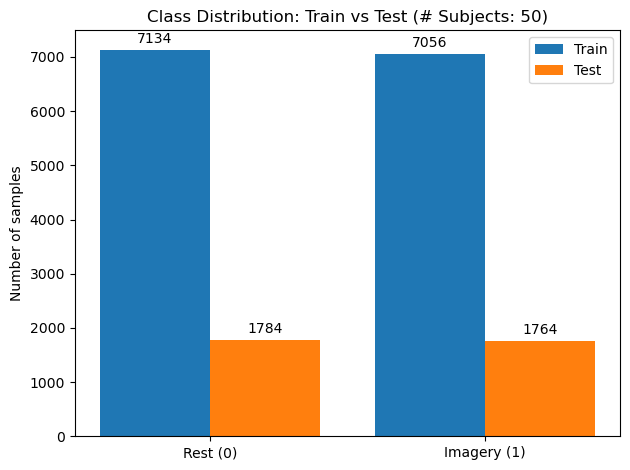

✅ Class distribution plot saved as 'output_img\class_distribution\class_distribution_50S.png'


In [14]:
# --- Check class distribution ---
s2.plot_class_distribution(y_train, y_test, n_subjects)

## STEP 3 - Model Evaluation and Metrics Visualization

Classification model is chosen and configured. A **Random Forest classifier** is instantiated with 100 trees and default depth settings, ensuring ***reproducibility*** with a fixed random seed.

In [15]:
# --- Choose and Configure Classifier ---
from sklearn.ensemble import RandomForestClassifier

# Replace the placeholder model
model = RandomForestClassifier()
pipeline.set_params(clf=RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
))

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))])

Classifier’s performance is evaluated using ***5-fold cross-validation*** on the training set.

The model is assessed by the ROC AUC metric, which measures its ability to distinguish between classes: *average* and *standard deviation* of the ROC AUC scores across folds are reported to indicate the model’s stability and effectiveness before final training.

In [16]:
# --- Cross-Validation on Training Set ---
from sklearn.model_selection import cross_val_score

# Evaluate model using ROC AUC with 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print(f"✅ Cross-validated ROC AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

✅ Cross-validated ROC AUC: 0.780 ± 0.009


The model is then trained on all the training data, the pipeline scales the features and then the classifier learns to tell apart rest and motor imagery signals.

In [17]:
# --- Train Model on Full Training Set ---
# Fit the pipeline (scaler + classifier) to training data
pipeline.fit(X_train, y_train)
print("✅ Model successfully trained on training data.")

✅ Model successfully trained on training data.


In this step, the trained model predicts the class labels and the probabilities for the test data. The predictions show whether each test sample is rest or imagery, and the probabilities indicate the confidence level for imagery.

In [18]:
# --- Make Predictions on Test Set ---
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of class 'Imagery'

df_compare = pd.DataFrame({
    'Predicted Label': y_pred,
    'Probability Imagery': y_proba
})
df_compare.head(10)  # show first 10 predictions

,Predicted Label,Probability Imagery
0,0,0.42
1,1,0.55
2,0,0.42
3,0,0.37
4,1,0.71
5,1,0.64
6,1,0.74
7,1,0.53
8,1,0.78
9,1,0.67


### STEP 3.1 - Metrics Visualization

Following model training, performance is **evaluated** and **visualized** using several functions:
- `plot_and_save_confusion_matrix()` generates the confusion matrix to show true and false classifications.
- `plot_precision_recall_curve()` creates precision-recall curves to analyze trade-offs between sensitivity and precision
- `plot_and_save_roc_curve()` produces ROC curves with AUC scores for overall classifier discrimination ability.

Metrics and plots are saved for reporting and further analysis using `save_metrics_log()` inside respectively *log* and *output_img* subfolders.

- ***Accuracy*** measures the percentage of correct predictions out of all samples.
- ***F1 score*** is the harmonic mean of precision and recall, useful when classes are imbalanced, balancing false positives and false negatives.
- ***ROC AUC*** measures the model’s ability to distinguish between classes across all classification thresholds, representing the area under the ROC curve: higher values indicate better performance.

In [19]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Calculate accuracy, F1 score, and ROC AUC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"🧾 Test Accuracy:  {accuracy:.3f}")
print(f"🧾 Test F1 Score:  {f1:.3f}")
print(f"🧾 Test ROC AUC:  {roc_auc:.3f}")

🧾 Test Accuracy:  0.716
🧾 Test F1 Score:  0.712
🧾 Test ROC AUC:  0.780


#### 1. Classification Report

The ***classification report*** includes precision, recall, F1-score, and support (number of true samples) for both rest and imagery classes.

In [20]:
from sklearn.metrics import classification_report

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      1784
           1       0.72      0.71      0.71      1764

    accuracy                           0.72      3548
   macro avg       0.72      0.72      0.72      3548
weighted avg       0.72      0.72      0.72      3548



#### 2. Confusion Matrix

The ***confusion matrix*** helps us visualize how well the model’s predictions match the true labels on the test set: it shows counts of **true positives**, **true negatives**, **false positives**, and **false negatives**, helping to identify specific types of classification errors.

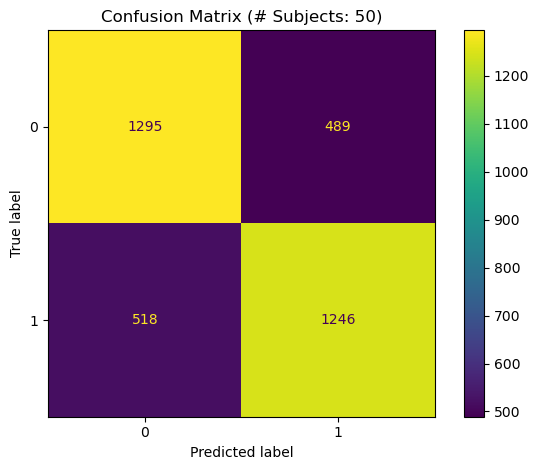

✅ Confusion matrix saved as 'output_img\confusion_matrix\confusion_matrix_50S.png'


In [21]:
s3.plot_and_save_confusion_matrix(pipeline, X_test, y_test, n_subjects=n_subjects)

#### 3. Precision-Recall Curve

The ***Precision-Recall curve*** illustrates, using predicted probabilities for the positive class, the trade-off between **precision** (how many of the predicted positive cases are actually correct) and **recall** (how many of the actual positive cases the model successfully identified) at different classification thresholds.

The **Average Precision (AP)** score is also computed and displayed as a summary metric of overall performance.

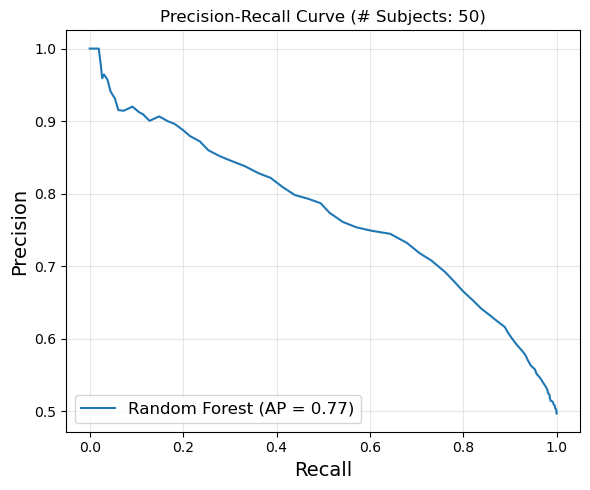

✅ Average Precision (AP) score: 0.769
✅ Precision-Recall curve saved as 'output_img\precision_recall\precision_recall_curve_random_forest_50S.png'


In [22]:
y_scores = pipeline.predict_proba(X_test)[:, 1]
precision, recall, ap = s3.plot_precision_recall_curve(y_test, y_scores, model_name="Random Forest", n_subjects=n_subjects)

#### 4. ROC Curve

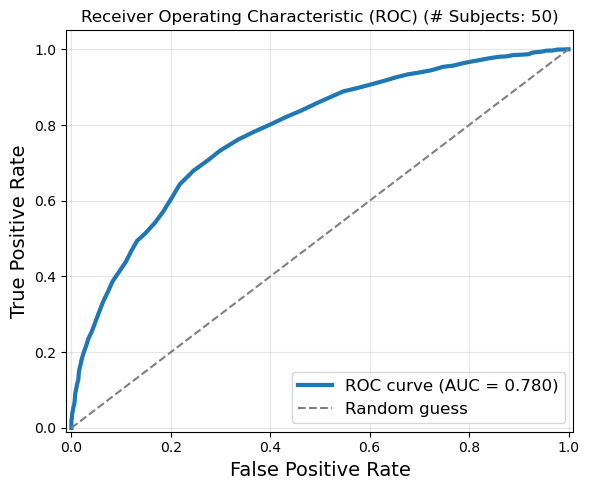

✅ ROC curve saved as 'output_img\roc_curve\roc_curve_50S.png'


In [23]:
s3.plot_and_save_roc_curve(y_test, y_scores, n_subjects=n_subjects)

#### 5. MCC and Balanced Accuracy

***Matthews Correlation Coefficient (MCC)*** is a balanced measure that takes into account true and false positives and negatives. It produces a value between -1 and 1, where 1 means perfect prediction, 0 means random guessing, and -1 indicates total disagreement.

***Balanced Accuracy*** calculates the average accuracy per class, helping to handle imbalanced datasets by giving equal importance to all classes regardless of their size.

In [24]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.3f}")
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.3f}")

Matthews Correlation Coefficient (MCC): 0.432
Balanced Accuracy: 0.716


In [25]:
# Log file generation
metrics_dict = {
    "Cross-validated ROC AUC (mean)": cv_scores.mean(),
    "Cross-validated ROC AUC (std)": cv_scores.std(),
    "Test Accuracy": accuracy,
    "Test F1 Score": f1,
    "Test ROC AUC": roc_auc,
    "Precision": precision,
    "Recall": recall,
    "Average Precision": ap,
    "Test MCC": mcc,
    "Balanced Accuracy": balanced_acc
}

s3.save_metrics_log(metrics_dict, model, n_subjects)

✅ Metrics saved to 'log\RandomForestClassifier_50S.txt'


## STEP 4 - Explainability & Feature Importance Analysis

To understand how our model makes predictions, we used SHAP (SHapley Additive exPlanations), a popular method for explaining machine learning models. SHAP helps us see which features (in this case, EEG channels) influence the model's decisions the most.

- **Get the model and data:**  
   We took the trained model from the pipeline and applied the same scaling (normalization) to the test data.

- **Calculate SHAP values:**  
   Using SHAP’s `TreeExplainer`, we computed SHAP values on the scaled test data. These values show how much each feature contributes to the prediction for each sample.

- **Name the features:**  
   We created a table with meaningful feature names linked to EEG channels, so the explanations are easier to interpret.

- **Summarize global importance:**  
   We generated a summary that shows which features are most important overall across all test samples.

Workflow for this phase:
1. Extracting the trained classifier (`clf`) from the pipeline, which holds the fitted Random Forest model.
2. Scaling the test data (`X_test`) using the pipeline’s scaler to apply the same normalization used during training, ensuring consistency.
3. SHAP explainer (`TreeExplainer`) is created for the tree-based model to enable interpretability.
4. Explainer computes SHAP values for each feature across all scaled test samples: these values represent how much each feature influences the model’s predictions and help us understand the decision process.

In [26]:
model = pipeline.named_steps['clf']
X_scaled = pipeline.named_steps['scaler'].transform(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)

In [27]:
# # Print of single feature values (uncomment to use)
# feature_index = 982
# values = X_scaled[:, feature_index]  # all rows, column 982 (feature 982 values for all samples)
# print(f"Values of feature {feature_index} across all samples:")
# print(values)  # uncomment to print all values if needed
# value = X_scaled[0, feature_index]
# print(f"Value of feature {feature_index} for sample 0: {value}")

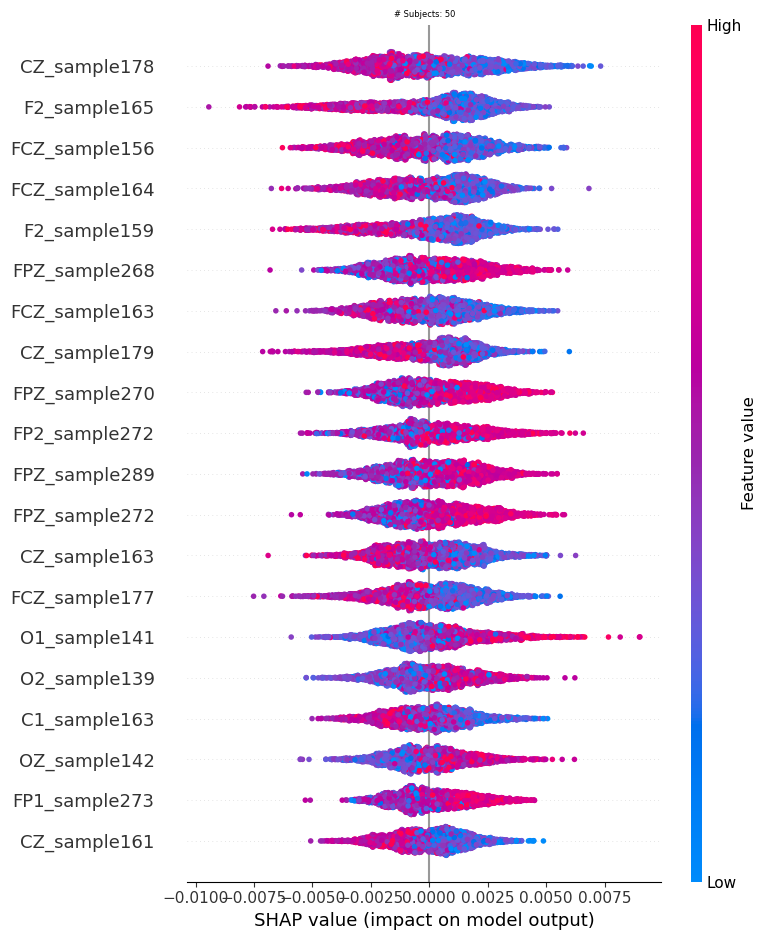

✅ Global SHAP summary plot saved: output_img\shap_global\shap_summary_global_50S.png
✅ JSON saved to: top_features_shap\top256_shap_50S.json


In [28]:
n_features_total = X_scaled.shape[1]
df_features_info = s4.create_feature_info_df(target_channels, n_features_total)     # mapping each feature index to corresponding EEG channel

feature_names = df_features_info['channel_sample'].tolist()
X_df = pd.DataFrame(X_scaled, columns=feature_names)

top_k = int(len(df_features_info) * 0.01)  # 1% of total features

df_shap, brain_area_percentages = s4.save_shap_global_summary_and_get_importance(   # saving most important features for analysis
    shap_values, X_df, df_features_info, n_subjects,
    top_k=top_k
)

In [29]:
# pprint(brain_area_percentages)    # uncomment to print brain area percentages (json file content)
df_shap

,index,channel_sample,brain_area,mean_abs_shap,rel_importance
0,4178,CZ_sample178,Central midline,0.001958,0.00178
1,13765,F2_sample165,Frontal,0.001934,0.00176
2,1356,FCZ_sample156,Fronto-central,0.001720,0.00156
3,1364,FCZ_sample164,Fronto-central,0.001678,0.00152
4,13759,F2_sample159,Frontal,0.001677,0.00152
...,...,...,...,...,...
251,10266,AF3_sample266,Anterior frontal,0.000488,0.00044
252,9461,FP2_sample261,Prefrontal,0.000484,0.00044
253,11070,AF4_sample270,Anterior frontal,0.000484,0.00044
254,10289,AF3_sample289,Anterior frontal,0.000484,0.00044


The following chart displays the most important features identified in this phase (along with their associated brain areas). This type of analysis can be particularly valuable for future studies aiming to optimize the computation of these metrics by focusing only on the features that have the greatest impact, neglecting the less relevant ones.

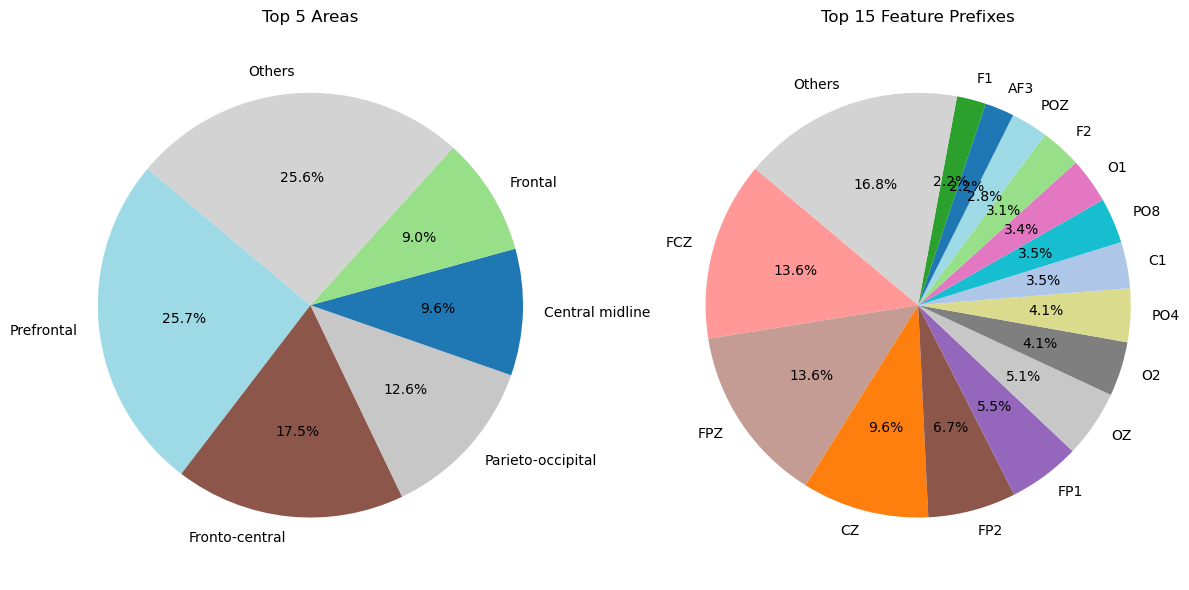

In [30]:
shap_folder = 'top_features_shap'
in_f = f'top{top_k}_shap_{n_subjects}S.json'
out_f = f'top{top_k}_shap_{n_subjects}S_analysis.png'

shap_data = s4.load_shap_json(os.path.join(shap_folder, in_f))
areas, prefixes, ctA, ctP = s4.process_data(shap_data, top_n_areas=5, top_n_prefixes=15)
fig = s4.plot_results(areas, prefixes, ctA, ctP, 5, 15, os.path.join(shap_folder, out_f))
plt.show()

## References

1. **PhysioNet EEG Motor Movement/Imagery Dataset**  
   Schalk, G., McFarland, D. J., Hinterberger, T., Birbaumer, N., & Wolpaw, J. R. (2004).  
   *BCI2000: A General-Purpose Brain-Computer Interface (BCI) System*. *Clinical Neurophysiology*, 115(3), 755–763.  
   [https://physionet.org/content/eegmmidb/1.0.0/](https://physionet.org/content/eegmmidb/1.0.0/)

2. **PhysioNet Standard Citation**  
   Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000).  
   *PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals*.  
   *Circulation* [Online], 101(23), e215–e220. RRID:SCR_007345.

3. **BCI2000 Official Project Page**  
   Wadsworth Center, New York State Department of Health.  
   [https://www.bci2000.org/mediawiki/index.php/Main_Page](https://www.bci2000.org/mediawiki/index.php/Main_Page)

4. **ChatGPT**  
   OpenAI. *Large Language Model used for project support, explanation, and code suggestions.*  
   [https://openai.com/chatgpt](https://openai.com/chatgpt)